In [1]:
import datetime
import glob
import os
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

from pathlib import Path
from PIL import Image

from torchvision.utils import save_image
from torchvision import transforms as T
# from agent.encoder import Encoder

from tactile_learning.models import *
from tactile_learning.utils import *
from tactile_learning.tactile_data import *

In [22]:
encoder = resnet18(pretrained=True, out_dim=512)

mod_name: collections, name: OrderedDict
mod_name: torch._utils, name: _rebuild_parameter
mod_name: torch._utils, name: _rebuild_tensor_v2


/home/irmak/miniconda3/envs/tactile_learning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/irmak/miniconda3/envs/tactile_learning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Get the two different episodes, crop them and see if you're getting
# close representations 

def load_one_episode(fn):
    with open(fn, 'rb') as f:
        episode = np.load(f)
        episode = {k: episode[k] for k in episode.keys()}
    return episode

ep1 = load_one_episode(
    fn = '/home/irmak/Workspace/tactile-learning/buffer/2023.05.25T18-24_last_frames_5_offset_expo_True_base_policy_vinn_openloop)experts_[22, 26]/20230525T182501_0_76.npz'
)
ep2 = load_one_episode(
    fn = '/home/irmak/Workspace/tactile-learning/buffer/2023.05.25T18-24_last_frames_5_offset_expo_True_base_policy_vinn_openloop)experts_[22, 26]/20230525T182551_1_76.npz'
)



In [4]:
img1 = ep1['pixels'][0] / 255. 
img2 = ep2['pixels'][0] / 255.
print(img1.mean(), img1.shape)

0.40199247117828624 (3, 480, 480)


In [5]:
data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/bowl_picking/after_rss'
roots = sorted(glob.glob(f'{data_path}/demonstration_*'))
data = load_data(
    roots = roots, 
    demos_to_use=[22,26]
)

def viewed_crop_transform(image):
    return crop_transform(image, camera_view=1)


diff_demo_steps = []
i = 0
old_demo_id = -1
while i <= len(data['image']['indices'])-1:
    demo_id, _ = data['image']['indices'][i]
    if old_demo_id != demo_id:
        diff_demo_steps.append(i)
    i += 1
    old_demo_id = demo_id

print(diff_demo_steps)

demo_id, image_id = data['image']['indices'][diff_demo_steps[0]]
print('demo_id: {}, image_id: {}'.format(demo_id, image_id))
exp1_img = load_dataset_image(
    data_path = data_path,
    demo_id = demo_id,
    image_id = image_id,
    view_num = 1,
    transform = T.Compose([
        T.Resize((480,640)),
        T.Lambda(viewed_crop_transform),
        T.Resize(480),
        T.ToTensor(),
        # T.Normalize(VISION_IMAGE_MEANS, VISION_IMAGE_STDS),
    ]),
    # as_int = True
)
demo_id, image_id = data['image']['indices'][diff_demo_steps[1]]
print('demo_id: {}, image_id: {}'.format(demo_id, image_id))
exp2_img = load_dataset_image(
    data_path = data_path,
    demo_id = demo_id,
    image_id = image_id,
    view_num = 1,
    transform = T.Compose([
        T.Resize((480,640)),
        T.Lambda(viewed_crop_transform),
        T.Resize(480),
        T.ToTensor(),
        # T.Normalize(VISION_IMAGE_MEANS, VISION_IMAGE_STDS),
    ]) ,
    # as_int = True
)

[0, 73]
demo_id: 0, image_id: 70
demo_id: 2, image_id: 71


In [6]:
print(exp2_img.mean())

tensor(0.3929)


Text(0.5, 0, 'Expert 2')

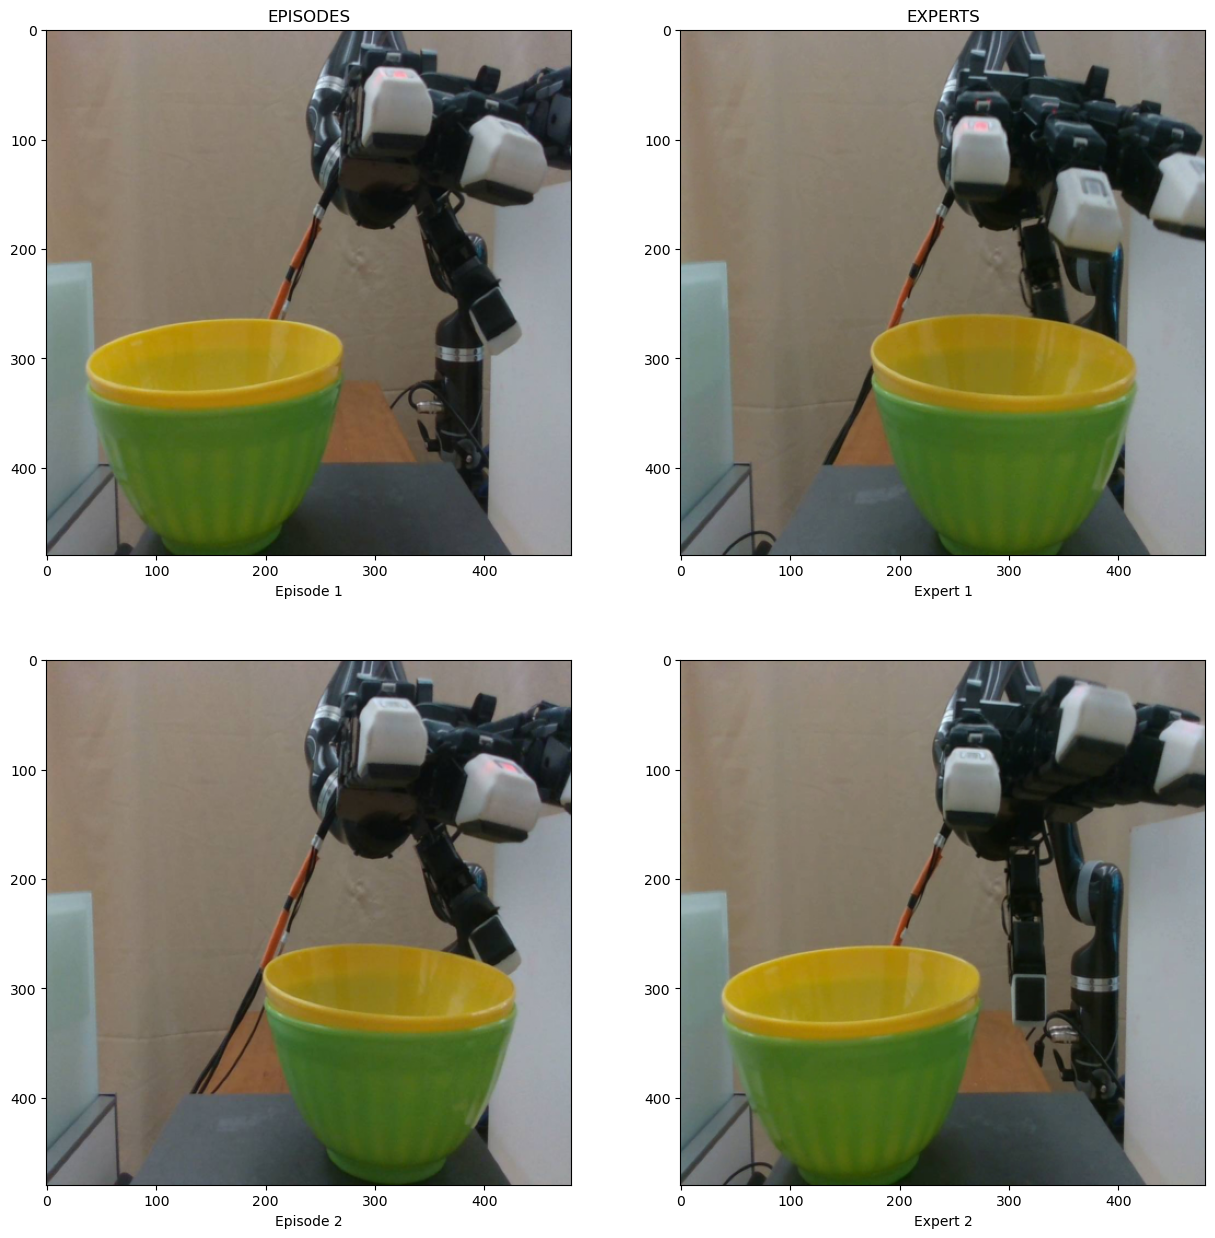

In [7]:
fig, axs = plt.subplots(figsize=(15,15), nrows=2, ncols=2)

axs[0][0].set_title('EPISODES')
axs[0][0].imshow(np.transpose(img1, (1,2,0)))
axs[0][0].set_xlabel('Episode 1')
axs[1][0].imshow(np.transpose(img2, (1,2,0)))
axs[1][0].set_xlabel('Episode 2')

axs[0][1].set_title('EXPERTS')
axs[0][1].imshow(np.transpose(exp1_img, (1,2,0)))
axs[0][1].set_xlabel('Expert 1')
axs[1][1].imshow(np.transpose(exp2_img, (1,2,0)))
axs[1][1].set_xlabel('Expert 2')

In [23]:

image_repr_transform = T.Compose([
    T.Normalize(VISION_IMAGE_MEANS, VISION_IMAGE_STDS)
])
print(img1.shape)
ep1_repr = encoder(image_repr_transform(torch.FloatTensor(img1).unsqueeze(0))).squeeze()
ep2_repr = encoder(image_repr_transform(torch.FloatTensor(img2).unsqueeze(0))).squeeze()
exp1_repr = encoder(image_repr_transform(torch.FloatTensor(exp1_img).unsqueeze(0))).squeeze()
exp2_repr = encoder(image_repr_transform(torch.FloatTensor(exp2_img).unsqueeze(0))).squeeze()

(3, 480, 480)


In [24]:
print(image_repr_transform(torch.FloatTensor(img1).unsqueeze(0)).mean())
print(image_repr_transform(torch.FloatTensor(exp1_img).unsqueeze(0)).mean())

tensor(-0.1823)
tensor(-0.1389)


In [25]:
print('EP 1 - EXP 1: {}'.format(torch.linalg.norm(ep1_repr - exp1_repr)))
print('EP 2 - EXP 1: {}'.format(torch.linalg.norm(ep2_repr - exp1_repr)))

print('EP 1 - EXP 2: {}'.format(torch.linalg.norm(ep1_repr - exp2_repr)))
print('EP 2 - EXP 2: {}'.format(torch.linalg.norm(ep2_repr - exp2_repr)))

EP 1 - EXP 1: 1.019797444343567
EP 2 - EXP 1: 0.8873538970947266
EP 1 - EXP 2: 0.9074615240097046
EP 2 - EXP 2: 1.0298641920089722


In [19]:
image_out_dir = '/home/irmak/Workspace/tactile-learning/tactile_learning/out/2023.05.11/13-21_bc_bs_32_epochs_500_lr_1e-05_bowl_picking_after_rss'
_, encoder, _ = init_encoder_info('cpu', image_out_dir, 'image', model_type='bc')

In [20]:
ep1_repr = encoder(image_repr_transform(torch.FloatTensor(img1).unsqueeze(0))).squeeze()
ep2_repr = encoder(image_repr_transform(torch.FloatTensor(img2).unsqueeze(0))).squeeze()
exp1_repr = encoder(image_repr_transform(torch.FloatTensor(exp1_img).unsqueeze(0))).squeeze()
exp2_repr = encoder(image_repr_transform(torch.FloatTensor(exp2_img).unsqueeze(0))).squeeze()

In [21]:
print('EP 1 - EXP 1: {}'.format(torch.linalg.norm(ep1_repr - exp1_repr)))
print('EP 2 - EXP 1: {}'.format(torch.linalg.norm(ep2_repr - exp1_repr)))

print('EP 1 - EXP 2: {}'.format(torch.linalg.norm(ep1_repr - exp2_repr)))
print('EP 2 - EXP 2: {}'.format(torch.linalg.norm(ep2_repr - exp2_repr)))

EP 1 - EXP 1: 1.1007224321365356
EP 2 - EXP 1: 1.2899278402328491
EP 1 - EXP 2: 1.1130540370941162
EP 2 - EXP 2: 1.861882209777832
